In [1]:
import pandas
import numpy as np
from ast import literal_eval
from matplotlib import pyplot as plt
from NetworkDataAnalysis import graph_tools_construction as gt

To do:
    
    -Fix large evec bug
    

## Pathway Scores using Featureset

In [2]:

def make_network(pathway_name, all_edge_dataframe, undirected):
    '''
    Make a network from the known edges.

    Inputs:
        pathway_name: a string for the name of a pathway
        all_edge_dataframe: a dataframe with all the edges
        undirected: boolean, False for directed edges and True for undirected edges
    
    Outputs:
        A: a numpy array of the adjacency matrix (directed)
        node_eids: a list of EntrezIDs whose indices correspond to the entries of A
    '''

    edge_dataframe = all_edge_dataframe[all_edge_dataframe['pathway_id'] == pathway_name]

    node_eids = np.array(list(set(edge_dataframe['src']).union(set(edge_dataframe['dest']))))

    n_nodes = len(node_eids)

    A = np.zeros((n_nodes, n_nodes))

    for _,row in edge_dataframe.iterrows():
        i = np.where(node_eids == row['src'])[0][0]
        j = np.where(node_eids == row['dest'])[0][0]
        A[i,j] = 1
        if undirected or row['direction'] == 'undirected':
            A[j,i] = A[i,j].copy()
    

    return A, node_eids

In [3]:
def calc_pathway_scores(centrality_measure, undirected, pid_2_eid, pathway_edges, featureset, file_ID):
    '''
    Inputs:
        centrality_measure: a string for the centrality measure to be used.
                            options are:
                                'degree'
                                'page_rank'
                                'large_evec
        undirected: boolean, False for directed edges and True for undirected edges
        pid_2_eid: a pandas dataframe with columnns 'EntrezID' and 'ProbeID' for 1 to 1 correspondence
        pathway_edges: a pandas dataframe with 'pathway_id', 'src', 'dst' and 'directed' columns.
                       load the file /data4/mankovic/GSE73072/probe_2_entrez.csv as a pandas dataframe or an example
        featureset: a pandas dataframe of a featureset with a column 'Unnamed: 0' for the ProbeID
        file_ID: a string for the name of the featureset
    Outputs:
        saves csv of scores to '/data4/mankovic/GSE73072/network_centrality/<directed or undirected>/gse73072_<directed or undirected>_'+centrality_measure+'_'+file_ID'.csv'
    '''


    # load names of the pathways and init pathway dataframe
    pathway_names = np.unique(np.array(pathway_edges['pathway_id']))

    pathway_scores = pandas.DataFrame(columns = ['pathway_id', 'unnormalized', 'path norm', 'feature path norm', 'avg degree norm', 'feature path count'])

    lengths = []

    scores_list = []

    ii=0
    # go through every pathway name
    for pathway_name in pathway_names:

        #make adjacency matrix
        A, n_eids = make_network(pathway_name, pathway_edges, undirected)

        # if gt.connected_components(A) == 1:
        #     print(pathway_name+' is connected!')

        #node eids as strings
        string_node_eids = [str(int(node)) for node in n_eids]

        #get featureset eids
        featureset_pids = list(featureset['Unnamed: 0'])

        featureset_eids = []
        #load eids from the probeids in the featureset
        for p in featureset_pids:
            if p in list(pid_2_eid['ProbeID']):
                featureset_eids += [pid_2_eid[pid_2_eid['ProbeID'] == p]['EntrezID'].item()]

        #find the featureset nodes in the pathway
        discriminatory_nodes = list(set(featureset_eids).intersection(set(string_node_eids)))

        #calculate pathway scores
        scores = 1+gt.centrality_scores(A, centrality_measure)

        #average degree
        degrees = np.sum(A,axis = 0)
        avg_degree = np.mean(degrees)
        max_degree =  np.max(degrees)

        #find the indices of the nodes in the adjacency matrix that correspond to nodes in the featureset
        idx = [string_node_eids.index(r) for r in discriminatory_nodes]

        #calculate pathway scores
        node_scores = scores[idx]

        if len(node_scores) > 0:
            pathway_score = np.sum(node_scores)

            # pathway_score = np.sum(node_scores)

            pathway_scores = pathway_scores.append({'pathway_id': pathway_name, 
                                                    'unnormalized': pathway_score, 
                                                    'path norm': pathway_score/len(scores), 
                                                    'feature path norm': pathway_score/len(node_scores), 
                                                    'avg degree norm': pathway_score/avg_degree, 
                                                    'max degree norm': pathway_score/max_degree, 
                                                    'feature path count': len(node_scores)}, 
                                                    ignore_index = True)

            scores_list.append(pathway_score)
            lengths.append(len(scores))

        if ii % 200 == 0:
            print('pathway '+str(ii)+' done')

        ii+=1
    
    plt.figure()
    plt.scatter(lengths, scores_list)
    plt.xlabel('Pathway Size')
    plt.ylabel('Centrality Score')

    pathway_scores = pathway_scores.sort_values(by = 'unnormalized', ascending=False).dropna()
    if undirected:
        pathway_scores.to_csv('/data4/mankovic/GSE73072/network_centrality/undirected/gse73072_undirected_'+centrality_measure+'_'+file_ID+'.csv', index = False)
    else:
        pathway_scores.to_csv('/data4/mankovic/GSE73072/network_centrality/directed/gse73072_directed_'+centrality_measure+'_'+file_ID+'.csv', index = False)

In [4]:
#load the data

metadata = pandas.read_csv('/data4/kehoe/GSE73072/GSE73072_metadata.csv')
# vardata = pandas.read_csv('/data4/kehoe/GSE73072/GSE73072_vardata.csv')

pathway_edges = pandas.read_csv('/data3/darpa/omics_databases/ensembl2pathway/reactome_human_pathway_edges.csv').dropna()

#change this for featureset
featureset = pandas.read_csv('/data4/mankovic/GSE73072/network_centrality/featuresets/diffgenes_gse73072_pval_and_lfc.csv')


pid_2_eid = pandas.read_csv('/data4/mankovic/GSE73072/probe_2_entrez.csv')



In [6]:
#calculate number of connected pathways

pathway_names = np.unique(np.array(pathway_edges['pathway_id']))

count = 0
for pathway_name in pathway_names:

    #make adjacency matrix
    A, n_eids = make_network(pathway_name, pathway_edges, True)

    if gt.connected_components(A) == 1:
        count += 1
    
count/len(pathway_names)

0.7511835875854813

In [5]:
calc_pathway_scores('large_evec', True, pid_2_eid, pathway_edges, featureset, 'pval_and_lfc')

R-HSA-1059683 is connected!
pathway 0 done


KeyboardInterrupt: 

In [12]:

calc_pathway_scores('page_rank', False, metadata, pathway_edges, featureset, 'pval_and_lfc')

R-HSA-1059683


KeyError: 'ProbeID'

pathway 0 done
pathway 200 done
pathway 400 done
pathway 600 done
pathway 800 done
pathway 1000 done
pathway 1200 done
pathway 1400 done
pathway 1600 done
pathway 1800 done


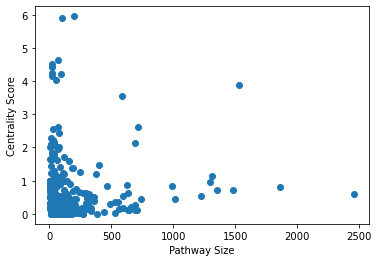

In [8]:
calc_pathway_scores('degree', False, metadata, pathway_edges, featureset, 'pval_and_lfc')

pathway 0 done
pathway 200 done
pathway 400 done
pathway 600 done
pathway 800 done
pathway 1000 done
pathway 1200 done
pathway 1400 done
pathway 1600 done
pathway 1800 done


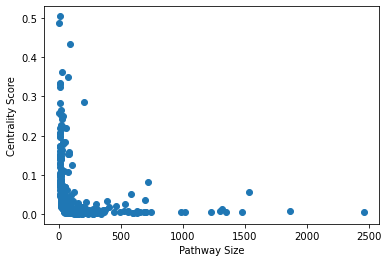

In [8]:
calc_pathway_scores('page_rank', True, metadata, pathway_edges, featureset, 'pval_and_lfc')

pathway 0 done
pathway 200 done
pathway 400 done
pathway 600 done
pathway 800 done
pathway 1000 done
pathway 1200 done
pathway 1400 done
pathway 1600 done
pathway 1800 done


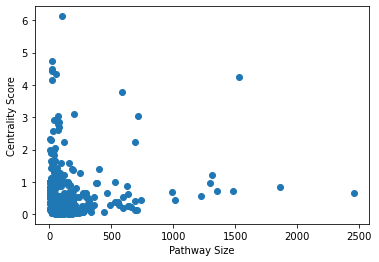

In [9]:
calc_pathway_scores('degree', True, metadata, pathway_edges, featureset, 'pval_and_lfc')

# Nothing useful after this line!

In [75]:
string_node_eids

['1029',
 '115209',
 '8717',
 '7186',
 '8737',
 '100506658',
 '8743',
 '4137',
 '5707',
 '5682',
 '5683',
 '5684',
 '5685',
 '5686',
 '5687',
 '5688',
 '5689',
 '5690',
 '5691',
 '5692',
 '5693',
 '5694',
 '148022',
 '5696',
 '572',
 '5698',
 '5699',
 '5700',
 '5701',
 '5702',
 '581',
 '5704',
 '5705',
 '3146',
 '5706',
 '3148',
 '5709',
 '5710',
 '5708',
 '5711',
 '5713',
 '5714',
 '5715',
 '5716',
 '5717',
 '5718',
 '596',
 '5720',
 '6233',
 '5721',
 '8795',
 '5719',
 '8797',
 '1630',
 '23643',
 '353376',
 '8772',
 '143471',
 '5747',
 '6774',
 '118',
 '637',
 '8837',
 '9861',
 '90249',
 '1676',
 '1677',
 '7311',
 '7314',
 '7316',
 '660',
 '1687',
 '23198',
 '6304',
 '708',
 '5317',
 '9414',
 '207',
 '208',
 '10971',
 '5339',
 '4836',
 '8428',
 '5366',
 '2810',
 '3836',
 '3837',
 '7431',
 '57099',
 '10000',
 '9491',
 '9500',
 '10018',
 '55075',
 '2339',
 '1828',
 '5414',
 '1830',
 '56616',
 '1829',
 '1832',
 '7979',
 '79658',
 '90427',
 '28988',
 '317',
 '836',
 '324',
 '839',
 '840',

In [24]:
pathway_names = np.unique(np.array(pathway_edges['pathway_id']))
pathway_name = pathway_names[0]
edge_dataframe = pathway_edges[pathway_edges['pathway_id'] == pathway_name]

edge_dataframe

,Unnamed: 0,src_type,src,dest_type,dest,direction,type,pathway_id
1,2,ENTREZID,9021.0,ENTREZID,3717.0,directed,Control(Out: INHIBITION of BiochemicalReaction),R-HSA-1059683
2,3,ENTREZID,9021.0,ENTREZID,3717.0,undirected,Binding,R-HSA-1059683
3,4,ENTREZID,9021.0,ENTREZID,3569.0,directed,Control(Out: INHIBITION of BiochemicalReaction),R-HSA-1059683
4,5,ENTREZID,9021.0,ENTREZID,3569.0,undirected,Binding,R-HSA-1059683
5,6,ENTREZID,9021.0,ENTREZID,3570.0,directed,Control(Out: INHIBITION of BiochemicalReaction),R-HSA-1059683
...,...,...,...,...,...,...,...,...
73,74,ENTREZID,5781.0,ENTREZID,3569.0,undirected,Binding,R-HSA-1059683
74,75,ENTREZID,5781.0,ENTREZID,3570.0,undirected,Binding,R-HSA-1059683
75,76,ENTREZID,5781.0,ENTREZID,867.0,undirected,Binding,R-HSA-1059683
76,77,ENTREZID,5781.0,ENTREZID,3716.0,undirected,Binding,R-HSA-1059683


In [40]:
node_pids = np.array(list(set(edge_dataframe['src']).union(set(edge_dataframe['dest']))))

n_nodes = len(node_pids)

node_pids
    

array([7297., 3716., 3717., 5781.,  867., 3569., 3570., 3572., 6772.,
       6774., 9021.])

In [39]:
row = edge_dataframe.iloc[0]
np.where(node_pids == row['src'])[0][0]
row['dest']

3717.0

In [51]:
A = np.zeros((n_nodes, n_nodes))

for _,row in edge_dataframe.iterrows():
    print(node_pids)
    print(row['src'])
    i = np.where(node_pids == row['src'])[0][0]
    j = np.where(node_pids == row['dest'])[0][0]
    A[i,j] = 1
    if row['direction'] == 'undirected':
        A[j,i] = A[i,j].copy()

[7297. 3716. 3717. 5781.  867. 3569. 3570. 3572. 6772. 6774. 9021.]
9021.0
[7297. 3716. 3717. 5781.  867. 3569. 3570. 3572. 6772. 6774. 9021.]
9021.0
[7297. 3716. 3717. 5781.  867. 3569. 3570. 3572. 6772. 6774. 9021.]
9021.0
[7297. 3716. 3717. 5781.  867. 3569. 3570. 3572. 6772. 6774. 9021.]
9021.0
[7297. 3716. 3717. 5781.  867. 3569. 3570. 3572. 6772. 6774. 9021.]
9021.0
[7297. 3716. 3717. 5781.  867. 3569. 3570. 3572. 6772. 6774. 9021.]
9021.0
[7297. 3716. 3717. 5781.  867. 3569. 3570. 3572. 6772. 6774. 9021.]
9021.0
[7297. 3716. 3717. 5781.  867. 3569. 3570. 3572. 6772. 6774. 9021.]
9021.0
[7297. 3716. 3717. 5781.  867. 3569. 3570. 3572. 6772. 6774. 9021.]
9021.0
[7297. 3716. 3717. 5781.  867. 3569. 3570. 3572. 6772. 6774. 9021.]
9021.0
[7297. 3716. 3717. 5781.  867. 3569. 3570. 3572. 6772. 6774. 9021.]
9021.0
[7297. 3716. 3717. 5781.  867. 3569. 3570. 3572. 6772. 6774. 9021.]
9021.0
[7297. 3716. 3717. 5781.  867. 3569. 3570. 3572. 6772. 6774. 9021.]
9021.0
[7297. 3716. 3717. 5781. 

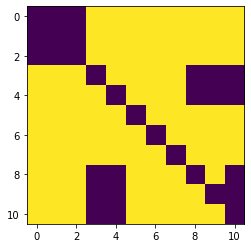

In [54]:
plt.imshow(A)

In [125]:
eid_pid_converter[eid_pid_converter['EntrezID']=='780']

,EntrezID,ProbeID
0,780,1007_s_at
7195,780,207169_x_at
8959,780,208779_x_at
11082,780,210749_x_at


In [129]:
# #entrez_id to probe_id
# def eid_to_pid(entrez_id):
#     probe_ids = []
#     for i in range(len(vardata['EntrezID'])):
#         if type(vardata['EntrezID'][i]) == str:
#             if entrez_id in literal_eval(vardata['EntrezID'][i]):
#                 probe_ids.append(vardata['ProbeID'][i])
#     return probe_ids



def add_connection(row, edges, eid_pid_converter):
    if row['src_type'] == 'ENTREZID' and row['dest_type'] == 'ENTREZID':
        src_eid = str(int(row['src']))
        src_probe_ids = list(eid_pid_converter[eid_pid_converter['EntrezID']==src_eid]['ProbeID'])

        dst_eid = str(int(row['dest']))
        dst_probe_ids = list(eid_pid_converter[eid_pid_converter['EntrezID']==dst_eid]['ProbeID'])

        for scr in src_probe_ids:
            for dst in dst_probe_ids:
                edges = edges.append( {
                                    'Souce':scr , 
                                    'Destination':dst, 
                                    'Direction':row['direction'], 
                                    'Type': row['type'],
                                    'Pathway_ID': row['pathway_id']
                                    }, 
                                    ignore_index = True)
    return edges


In [131]:
#undirected edge pandas dataframe
edges = pandas.DataFrame(columns = ['Souce' , 'Destination', 'Direction', 'Type', 'Pathway_ID'])


for i in range(200):
    row = pathway_data.iloc[i]
    # if row['direction'] == 'undirected':
    edges = add_connection(row, edges, eid_pid_converter)
    edges = edges.drop_duplicates()

edges

,Souce,Destination,Direction,Type,Pathway_ID
0,206359_at,205841_at,directed,Control(Out: INHIBITION of BiochemicalReaction),R-HSA-1059683
1,206359_at,205842_s_at,directed,Control(Out: INHIBITION of BiochemicalReaction),R-HSA-1059683
2,206360_s_at,205841_at,directed,Control(Out: INHIBITION of BiochemicalReaction),R-HSA-1059683
3,206360_s_at,205842_s_at,directed,Control(Out: INHIBITION of BiochemicalReaction),R-HSA-1059683
4,214105_at,205841_at,directed,Control(Out: INHIBITION of BiochemicalReaction),R-HSA-1059683
...,...,...,...,...,...
686,212296_at,201699_at,undirected,Binding,R-HSA-109581
687,212296_at,200017_at,directed,Control(Out: ACTIVATION of BiochemicalReaction),R-HSA-109581
688,212296_at,221700_s_at,directed,Control(Out: ACTIVATION of BiochemicalReaction),R-HSA-109581
689,212296_at,200814_at,undirected,Binding,R-HSA-109581


In [132]:
edges.to_csv('tow_pathway_data.csv', index = False)

(0, Unnamed: 0      1
src_type      NaN
src           NaN
dest_type     NaN
dest          NaN
direction     NaN
type          NaN
pathway_id    NaN
Name: 0, dtype: object)
(1, Unnamed: 0                                                  2
src_type                                             ENTREZID
src                                                    9021.0
dest_type                                            ENTREZID
dest                                                   3717.0
direction                                            directed
type          Control(Out: INHIBITION of BiochemicalReaction)
pathway_id                                      R-HSA-1059683
Name: 1, dtype: object)
(2, Unnamed: 0                3
src_type           ENTREZID
src                  9021.0
dest_type          ENTREZID
dest                 3717.0
direction        undirected
type                Binding
pathway_id    R-HSA-1059683
Name: 2, dtype: object)
(3, Unnamed: 0                                      

KeyboardInterrupt: 